# This report is formatted with respect to the rubric, rather than in a more traditional report layout.
### The rubric prompt will be followed by the condition(s) for full credit, then discussion about my findings for that prompt.  After this is the actual code from which my findings were produced.

# Prompt: Project Topic  
### Pt. 1: Give a clear explination of what the project is about AND clearly state both the type of learning/algorithms AND type of task
### Pt. 2: Clearly state the motivation or goal for the project  

This project seeks to solve the binary classification problem presented by the Occupancy dataset.
The goal is to properly identify whether or not a room is occupied based on the predictors (such as temperature, humidity) measured in the room.  The actual occupancy status of the rooms are derived from time-stamped pictures taken every minute - though all we use for this classification problem are the ground truth occupancy labels.  
The ability to identify the occupancy status of a room based only on easy-to-collect measurements such as temperature, humidity, etc. is useful as it could be used to guide a multitude of business decisions for the rooms in question.  For example, thinking about using space efficiently, if a few specific rooms have very little occupancy, it may be useful to use these rooms for things other than what they are currently employed for.  Or say that almost all rooms show little occupancy, this may be a sign that a given office space is no longer required and can be sold/turned to new use cases.  These are examples that have the potential to save countless resources in a company.  In the headspace of trying to save resources, we will also try to find the simplest model possible while preserving the accuracy of our predictions.  Simpler models would require fewer sensors and would fit faster, meaning we would save even more.
To do this analysis we will employ both a linear SVC as well as a random forest classifier.  We also ended up utilizing a Logistic Regression for reasons to follow in the upcoming sections.
In the original (cited) paper, some information from the time stamps was used in the models.  Here we attempt to go without to see if a model can be created using only a few simple to install/monitor sensors which can stand up to a more complex approach. It is also the case that the timeframe of the data collected is not too long, and it seems a bit wrong to try to draw temporal conclusions with such a small timeframe. It is also worth noting that the original paper had more sensors (and thus more possible predictors) than is supplied in the dataset.  This meshes well with our aim of producing a simpler model.  Less predictors and fewer sensors would lead to savings for those employing such a model.

# Prompt: Data
### Pt. 1: Give Brief explination of where the data is from/how it was gathered.  Cite the dataset appropriately
### Pt. 2: Describe the data including the data size appropriately  

Data source:  
These data come from the UCI dataset archive found at https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+   
The data comes in three parts including two testing sets and a training set.  The two test sets are to account for those that had the door open vs. closed when the room was occupied.  From this we will of course first use the training set, before testing on each of the testing sets.  There are by default 6 predictors: Date, Temperature (C), Relative Humidity (%), Light (Lux), CO2 (ppm), and Humidity Ratio (Derived from temperature and relative humidity) as well as one response, the Occupancy label (0 for unoccupied, 1 for occupied).  The temperature, relative humidity, light, and CO2 were all measured from sensors.  Occupancy was determined by time-stamped pictures.  

It is noted in the original paper (cited below) that they used both of the training data sets and found the best accuracies from training LDA, CART, and RF models.  They also note that using only one predictor (temperature) the LDA model has great accuracy, the values of which are [85%, 83%] for testing sets 1 and 2 respectively.   

APA Citation:  
Candanedo, L. M., & Feldheim, V. (2016). Accurate occupancy detection of an office room from light, temperature, humidity and CO2 measurements using statistical learning models. Energy and Buildings, 112, 28-39.Candanedo, L. M., & Feldheim, V. (2016). Accurate occupancy detection of an office room from light, temperature, humidity and CO2 measurements using statistical learning models. Energy and Buildings, 112, 28-39.

Data Description:  
Our training data has 8143 samples, the first test set has 2665 samples, and the second test set has 9752 samples.  All of them contain the seven columns mentioned in the predictors and response above.  The default datatypes/descriptions of the columns are as follows:  
Date, an object, the date/time the measurements were taken  
Temperature, a float, the degrees celcius in a room   
(Relative) Humidity, a float, the % relative humidity in a room  
Light, a float, the Lux measured in a room  
CO2, a float, the CO2 measured in a room in ppm.  
HumidityRatio, a float, derived from the temperature and relative humidity in (kg(water) - vapor) / kg(air)  
Occupancy, an integer, the class labels where 1 represents an occupied room and 0 represents an unoccupied room  
As mentioned previously, the Temperature, Humidity, Light, and CO2 were recorded via sensors.  Humidity Ratio is derived from two other predictors.  Occupancy was observed via time-stamped pictures (which also gives the Date).  While the data will be used mostly in its currently split form (1 training, 2 test sets), we will also combine it early on so as to clean out all of the possibly unwanted entries before we continue with the analysis.  

In [1]:
#Import everything we'll need
#general tools
import pandas as pd
import numpy as np
import math
import sklearn
#plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#VIF tests
from statsmodels.stats.outliers_influence import variance_inflation_factor
#linear SVC tools
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
#Random forest tools
from sklearn.ensemble import RandomForestClassifier
#evaluation tools
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_recall_curve
import time

In [2]:
#Read in all our data
#   https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+      
train = pd.read_csv(".\Data\datatraining.txt")
#two testing sets to account for door opening, according to the original paper linked below:
# https://www.researchgate.net/profile/Luis_Candanedo_Ibarra/publication/285627413_Accurate_occupancy_detection_of_an_office_room_from_light_temperature_humidity_and_CO2_measurements_using_statistical_learning_models/links/5b1d843ea6fdcca67b690c28/Accurate-occupancy-detection-of-an-office-room-from-light-temperature-humidity-and-CO2-measurements-using-statistical-learning-models.pdf?origin=publication_detail
test = pd.read_csv(".\Data\datatest.txt") 
test2 = pd.read_csv(".\Data\datatest2.txt") 

#Set up the combined dataframes to clean up everything before we do analysis.  This just combines the dataframes vertically
to_clean = pd.concat([train, test, test2], axis = 0)

In [3]:
#Shape of data
print(train.shape, test.shape, test2.shape, to_clean.shape)

(8143, 7) (2665, 7) (9752, 7) (20560, 7)


In [4]:
#Show dataframe head
train.head()
# test.head()
# test2.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [5]:
#Show initial dtypes of columns
train.dtypes

date              object
Temperature      float64
Humidity         float64
Light            float64
CO2              float64
HumidityRatio    float64
Occupancy          int64
dtype: object

# Prompt: Data Cleaning
### Clearly explain how and why data cleaning steps were performed AND conclusions or discussions AND proper visualizations.  
For this data cleaning the first step was to combine all of our data into one big dataframe for ease of cleaning.  We could, of course, have simply repeated the cleaning process three times, but combining then re-splitting seemed more efficient.  
Following the combination, the 'date' column was dropped.  As mentioned before, this data was kept in the original paper but our aim is to create a simpler but still relatively accurate model that relies on only a few sensors to hopefully improve the ease in which such a system could be enacted, and the training data only has a few days of observation time making it hard to draw temporal conclusions.  
Next we changed the 'Occupancy' column to be a categorical variable instead of an Int64, reflecting its true nature as the binary classification label.  
Then to get a general feel of the distribution of the labels we check the overall distribution of the labels and find that there is an overwhelmingly large amount of 0's - representing empty rooms.  This will come in to play more during our analysis of our models as this unbalanced distribution shows that looking just at accuracy may not be the best idea here.  
Subsequently we check for NA's and Nulls of the more traditional variety as well as string-based, finding none.  We also check for possible 'hidden' NA's such as those encoded by 999's or 0's where they shouldn't be using violin plots, and again find none.  This also shows us the rough distribution of our predictors which we can use to identify outliers.  The two predictors which catch the eye as possible issues are Light and CO2.  Lacking domain knowledge, a quick google search shows that common levels of Lux in a building are around 1,000 and outdoors it is around 10,000.  As such the violin plots' shape isn't nearly as dire as it appeared at first glance, and we remove none of the rows based off of their Lux values- though it could be possible that some of the 0 values are placeholders for NA's, there isn't enough evidence from that alone to throw away the rows as it could just be a dark room.  Another google search looking for the average CO2 in an office in ppm. says that it is recommended to keep the CO2 levels below 1,000 but that the occupational safety standard in an industrial workplace is 5,000 ppm.  As such we again see no cause to remove any rows based off of these predictors.  
From our cleaning steps above, it is clear after the fact that we did not need to combine our dataframes and could easily have done the steps on each dataframe itself.  All the better to know for future analysis.  As it is, we will simply apply the drop and datatype change to our three dataframes and move on knowing we checked for possible issues and seem to be in the clear.  
Once we are back to looking at only the training data we will begin with the EDA step in which we will begin to examine our training data with more rigor.  It is expected that there may be some problems with feature selection, as it is clear that there will be some correlation and multicollinearity between our features.  The clearest example of this is that one of the features (HumidityRatio) is derived from two of the others.  The strategy for analysis coming up will be to examine the predictors and see the extent to which such problems occur so as to address them or to justify ignoring them for our models.

In [6]:
#First clean the dtypes
#remove date column as we won't use it here
to_clean.drop(columns = 'date', inplace = True)
#set occupancy to be a categorical variable with 0 being unoccupied, 1 being occupied.
to_clean['Occupancy'] = to_clean['Occupancy'].astype('category')

In [7]:
#check head
to_clean.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,23.18,27.2720,426.0,721.25,0.004793,1
2,23.15,27.2675,429.5,714.00,0.004783,1
3,23.15,27.2450,426.0,713.50,0.004779,1
4,23.15,27.2000,426.0,708.25,0.004772,1
5,23.10,27.2000,426.0,704.50,0.004757,1


The overall percent unoccupied is: 0.769


Text(0.5, 0, 'Occupancy Status')

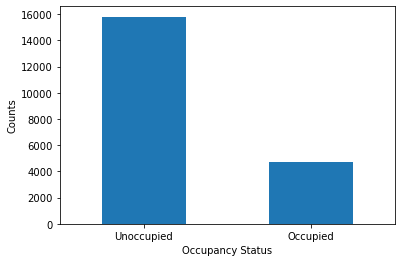

In [8]:
#plot distribution of labels. Can see it's very imbalanced overall. Usually unoccupied
print(f"The overall percent unoccupied is: {round(len(to_clean[to_clean['Occupancy'] == 0]) / len(to_clean),3)}")
to_clean['Occupancy'].value_counts().plot(kind = 'bar') 
ax = plt.gca()
#set labels
ax.set_xticklabels(["Unoccupied", "Occupied"]) 
plt.xticks(rotation = 0) #make labels upright
plt.ylabel("Counts")
plt.xlabel("Occupancy Status")

In [9]:
#check for nulls/na's that we know about.  First the more usual types including string nulls
a = [np.nan, None, [], {}, 'NaN', 'Null','NULL','None','NA','?','-', '.','', ' ', '   '] #list of all the nulls we've learned about
#check if any row has any of the nulls from a, if we find one then add one to the total counts of nulls
to_clean.T.isin(a).any().sum() #no string nulls either, great!

0

Text(0.5, 0, 'HumidityRatio')

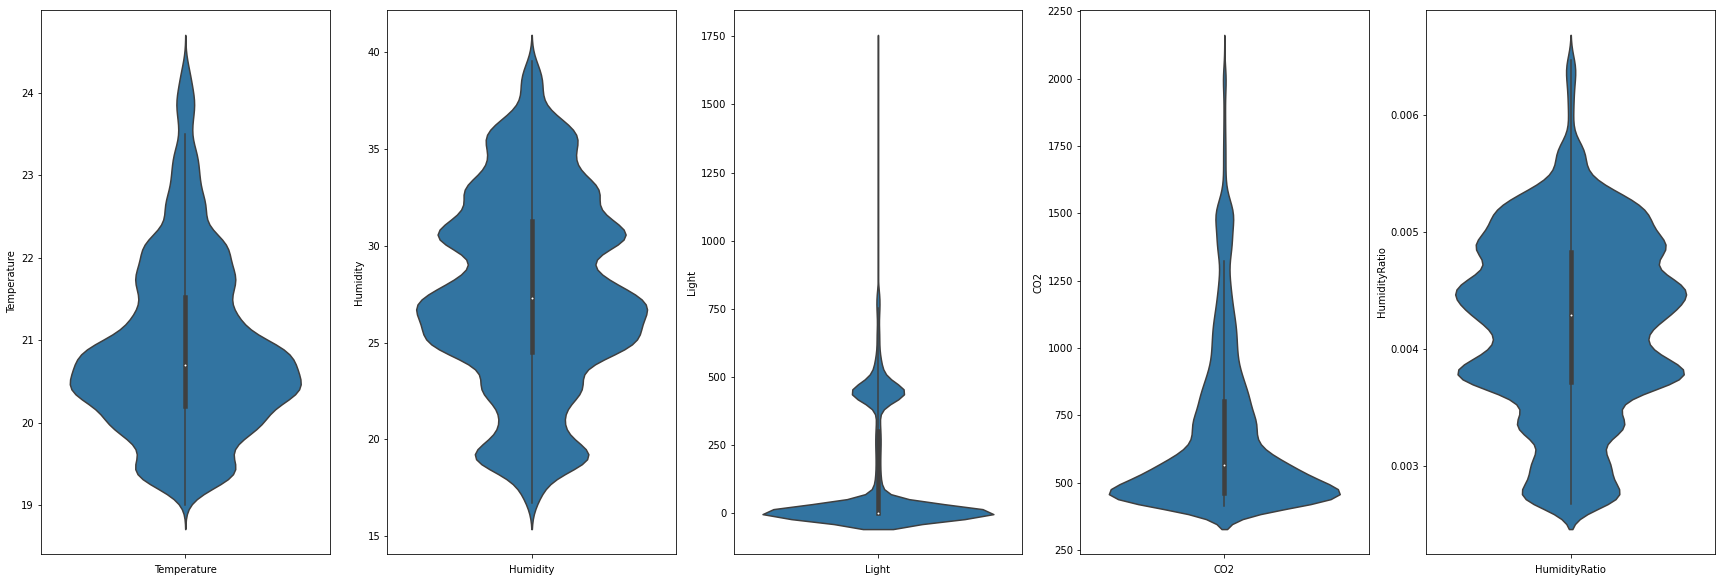

In [10]:
#check violin plot for all predictors, checking for 0's where there shouldn't be or something like 999s which can be used as NAs
fig = plt.figure(figsize = (30,10))
gs = fig.add_gridspec(1,5)
#plot temp violin
ax = fig.add_subplot(gs[0,0])
sns.violinplot(data = to_clean, y = 'Temperature' )
ax.set_xlabel("Temperature")
#plot humidity violin
ax = fig.add_subplot(gs[0,1])
sns.violinplot(data = to_clean, y = 'Humidity')
ax.set_xlabel("Humidity")
#plot light violin
ax = fig.add_subplot(gs[0,2])
sns.violinplot(data = to_clean, y = 'Light')
ax.set_xlabel("Light")
#plot co2 violin
ax = fig.add_subplot(gs[0,3])
sns.violinplot(data = to_clean, y = 'CO2')
ax.set_xlabel("CO2")
#plot humidityratio violin
ax = fig.add_subplot(gs[0,4])
sns.violinplot(data = to_clean, y = 'HumidityRatio')
ax.set_xlabel("HumidityRatio")

In [11]:
#Only steps required are to drop 'date', change the dtype of 'Occupancy', can do that individually for each dataframe here
#remove date column as we won't use it here
train.drop(columns = 'date', inplace = True)
test.drop(columns = 'date', inplace = True)
test2.drop(columns = 'date', inplace = True)
#set occupancy to be a categorical variable with 0 being unoccupied, 1 being occupied.
train['Occupancy'] = train['Occupancy'].astype('category')
test['Occupancy'] = test['Occupancy'].astype('category')
test2['Occupancy'] = test2['Occupancy'].astype('category')

In [12]:
#check dtypes, heads
print(train['Occupancy'].dtype, test['Occupancy'].dtype, test2['Occupancy'].dtype)
# train.head()
# test.head()
# test2.head()

category category category


# Prompt: Exploratory Data Analysis
### Simple plots, at least two of the following (or similar): Good analysis/conclusions/discussions, correlation matrix w/ analysis, extra EDA (e.g. stat. tests)  
Here I began by repeating some of the plots that I had done above, but this time with only the training data to see if there were any discrepancies between the training and full datasets which would indicate some sort of bias in the selection of the training data from the full set of all data.  First up is looking at the distribution of the labels.  We find that in the training set about 79% of rooms are unoccupied, comparable to the 77% overall.  Next are the violin plots of each of our predictors which show nearly identical distributions and IQRs as the overall distribution.  With this we can move on assuming that the training data is a representative sample of the full data.   
A pairplot is then created to examine the relationships between the predictors, as well as to get another view of the distributions of the predictors themselves with the KDE plots on the diagonals.  We can see some interesting distributions here.  For instance in the Temperature KDE we see that there appear to be two more 'usual' temperatures measured in a room with a bit of a skew to the right.  A first guess may be that this represents rooms which are empty and rooms which are occupied in the peaks and maybe the skew could be rooms which are occupied with more than one individual.  Humidity produces some more pronounced peaks with similar possible explanations.  Light has a seemingly easier to understand distribution mirroring the distribution of the Occupancy label.  A large peak near zero showing a presumably empty room, then a smaller peak representing an occupied room.  This is evidence that Light will probably be a very important predictor for the occupancy status of a room.  CO2 has a singular peak with a tail which seems a bit harder to interpret.  I would have initially expected twin peaks rather than the singular one, but it could be the case that it is the same as Light but with a baseline minimum amount of CO2 in the room when occupied with some spread depending on the physical characteristics of those occupying the room.  Finally HumidityRatio has a distribution closely resembling that of Temperature which makes sense as it is in part derived from the Temperature variable.   
Switching to looking at the off-diagonals we can see some fairly strong evidence of multicollinearity which we should examine further, such as in the HumidityRatio / Humidity cell.  This is expected as it is a derived quantity, but it will be worth examining via actual statistical tests to see the extent of the multicollinearity, and if it exists strongly between other predictors as well.  
The statistical test chosen first is the VIF calculations for our predictors.  A VIF of 5 or higher indicates highly correlated, multicollinear predictors.  We can see when we include all the predictors that we have insanely high VIF values, which we expect as HumidityRatio is itself derived from two of the others.  As such we attempt to remove HumidityRatio (as it has the highest VIF) and reassess the scores.  We again see relatively high values and continue to remove the highest VIF until we get scores at or below 5 for all of the remaining predictors.  This is a simple feature selection method which we will not use alone, but will use to help guide our more thorough feature selection in the 'models' section of the report along with the correlation values themselves.  We can see below that to get to a less-than-highly correlated situation we must remove all but Temperature and Light as our predictors.  
We then seek to assess the correlation values themselves via a correlation matrix.  Going row by row, we see a moderate correlation between Temp and Light, as well as Temp and CO2.  Followed by a moderate correlation between Humidity and CO2 as well as a high correlation between Humidity and HumidityRatio (of course). Then a moderate correlation between Light and CO2, and finally a moderate correlation between CO2 and HumidityRatio.  
We know from lecture that random forests help to decorrelate trees, and it can greatly help with correlated predictors, but it doesn't always fix them enough.  HumidityRatio is a problem for both multicollinearity as well as correlation, and probably won't add much value to the model.  It will not be cut out quite yet, but it will have a mark against it as we move in to the feature selection in the 'models' section.  Because of the decorrelation via random forests, it may be okay for us to keep Temp, CO2, and Light as their VIF values are high but not greater than 10 (a commonly used cutoff for unacceptable high collinearity).  Similarly for our linear SVC, our regularization parameter (C) will help us mitigate the issues of correlated and/or collinear predictors to an extent.

The training subset percent unoccupied is: 0.788


Text(0.5, 0, 'Occupancy Status')

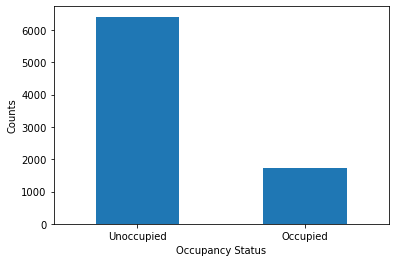

In [13]:
#Redo some plots from above but now focusing on training set alone
print(f"The training subset percent unoccupied is: {round(len(train[train['Occupancy'] == 0]) / len(train),3)}")
train['Occupancy'].value_counts().plot(kind = 'bar')
ax = plt.gca()
#set labels
ax.set_xticklabels(["Unoccupied", "Occupied"]) 
plt.xticks(rotation = 0) #make labels upright
plt.ylabel("Counts")
plt.xlabel("Occupancy Status")

Distribution of labels is nearly the same, good sign!

Text(0.5, 0, 'HumidityRatio')

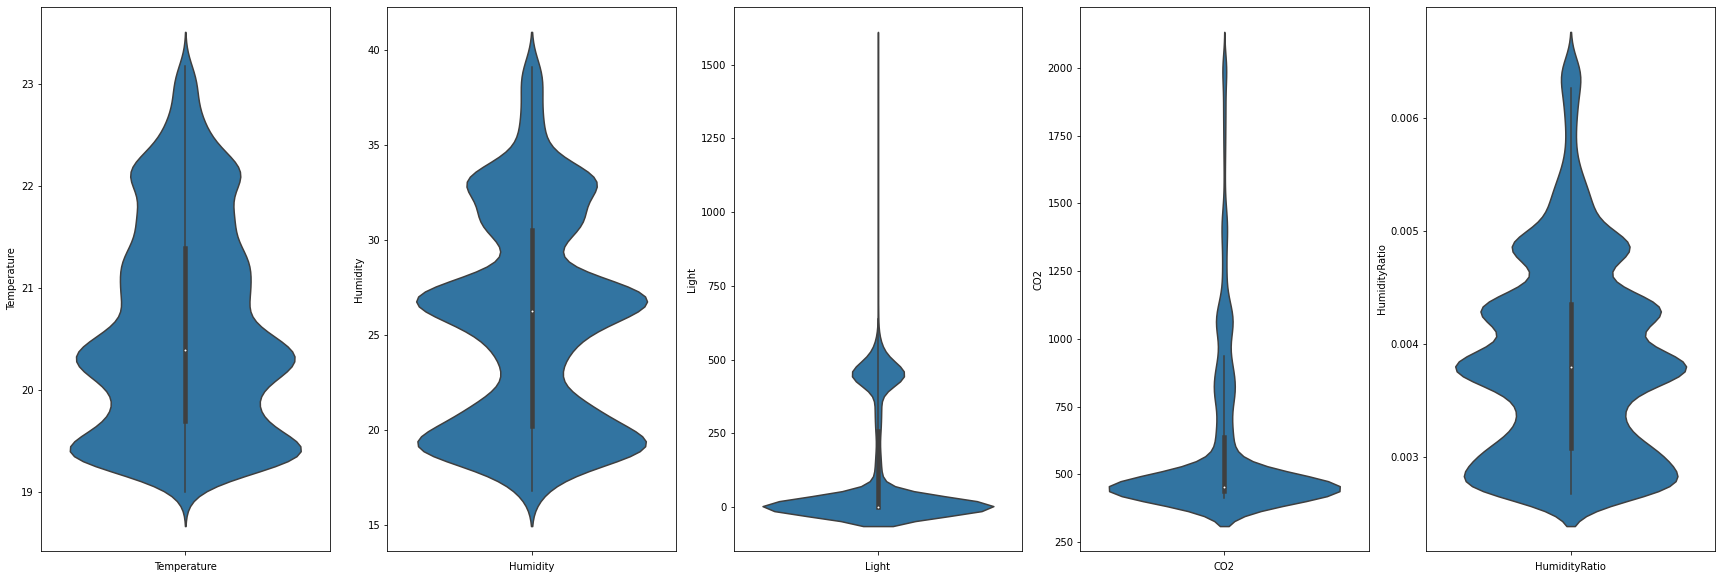

In [14]:
#redo violin plots now on training data, have more detail here
fig = plt.figure(figsize = (30,10))
gs = fig.add_gridspec(1,5)
# temp violin
ax = fig.add_subplot(gs[0,0])
sns.violinplot(data = train, y = 'Temperature' )
ax.set_xlabel("Temperature")
# humidity violin
ax = fig.add_subplot(gs[0,1])
sns.violinplot(data = train, y = 'Humidity')
ax.set_xlabel("Humidity")
# light violin
ax = fig.add_subplot(gs[0,2])
sns.violinplot(data = train, y = 'Light')
ax.set_xlabel("Light")
# co2 violin
ax = fig.add_subplot(gs[0,3])
sns.violinplot(data = train, y = 'CO2')
ax.set_xlabel("CO2")
# humidityratio violin
ax = fig.add_subplot(gs[0,4])
sns.violinplot(data = train, y = 'HumidityRatio')
ax.set_xlabel("HumidityRatio")

Distribution within predictors looks the same as full dataset, good sign!  Want to examine distribution more, do so via pairplot so as to do basic check for multicollinearity as well.

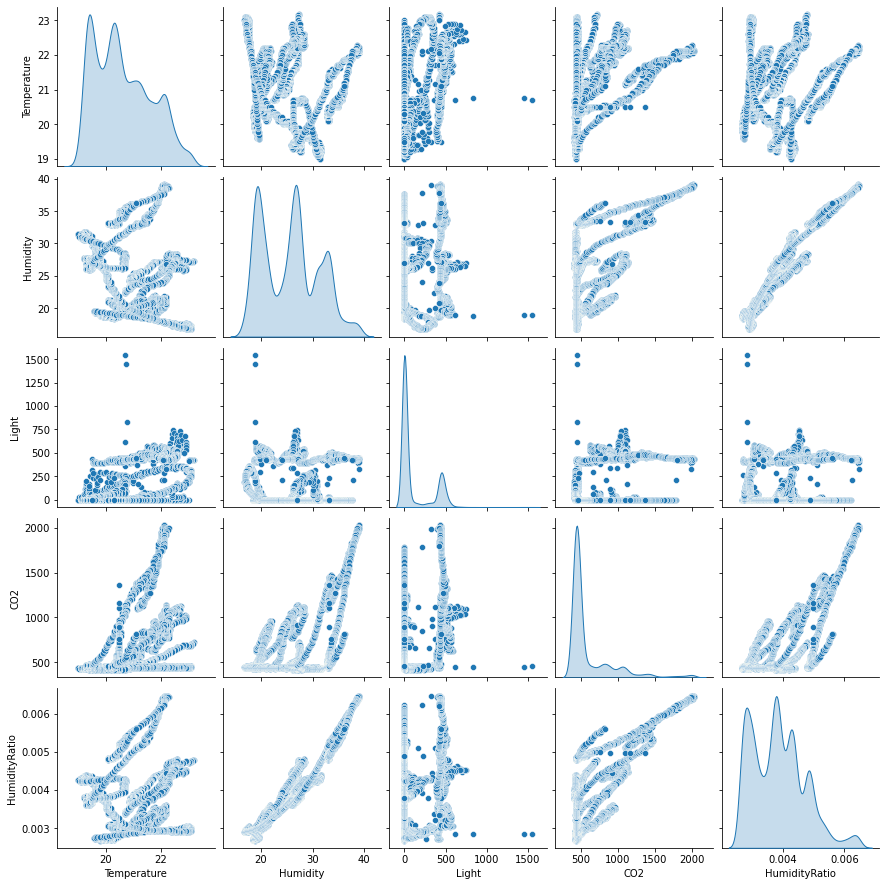

In [15]:
#Create pairplot, examine dists. and collinearity
sns.pairplot(train, diag_kind = 'kde')

Clear evidence of collinearity (e.g. Humidity/HumidityRatio cell) with a near straight line.  To be expected in this case as it's a derived variable.  Also see none of the variables are normally distributed by KDEs, CO2 closest to being so a the low values but with a skew.  First pass guess is that since most rooms unoccupied, and unoccupied rooms will presumably have lower CO2, the normally distributed CO2 is for the empty rooms and the tail represents occupied rooms.  Light seems to be amazing similar to distribution of labels alone, may be the best predictor from what we see here alone.  Twin peaks seem to represent unoccupied/occupied light levels.

In [16]:
#check VIF to verify there exists multicolin, to assess how much (This is a stat. test, mention it, as it counts towards an extra point here it seems!)
X = train[['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']]
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif_data

,feature,VIF
0,Temperature,22.896769
1,Humidity,538.779235
2,Light,3.031914
3,CO2,18.722682
4,HumidityRatio,692.832601


VIF of HumidityRatio is nearly at 700, we expected it to be colinear though.  Try removing

In [17]:
#Check VIF values if we removed HumidityRatio
# X = train[['Temperature', 'Humidity', 'Light', 'CO2']]
# vif_data = pd.DataFrame()
# vif_data['feature'] = X.columns
# vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
# vif_data

Still have a high VIF in humidity of around 28, as well as temp at around 21.  Try removing highest VIF again.

In [18]:
#Check VIF values if we removed HumidityRatio and Humidity
# X = train[['Temperature', 'Light', 'CO2']]
# vif_data = pd.DataFrame()
# vif_data['feature'] = X.columns
# vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
# vif_data

Now have the highest VIF being CO2 at 8.7, still pretty high.  Try removing and see how the last two fare.

In [19]:
#Check VIF values if we removed HumidityRatio, Humidity, and CO2
X = train[['Temperature', 'Light']]
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif_data

,feature,VIF
0,Temperature,1.433063
1,Light,1.433063


Now have a very low VIF, both at around 1.43.  Still past being non-correlated, but no longer in the 'highly correlated' realm of VIF>5.  Good first-pass idea for feature selection.  Lets examine the correlation more in-depth now.

In [20]:
# train.head()

In [21]:
#get correlation values themselves, use a copy of train so as to change occupancy dtype to include it
train_corr = train.copy()
train_corr['Occupancy'] = train_corr['Occupancy'].astype('float')
corr = train_corr.corr()
#plot correlation values to show correlation matrix, set precision to be 3 decimal places
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
Temperature,1.000,-0.142,0.650,0.560,0.152,0.538
Humidity,-0.142,1.000,0.038,0.439,0.955,0.133
Light,0.650,0.038,1.000,0.664,0.230,0.907
CO2,0.560,0.439,0.664,1.000,0.627,0.712
HumidityRatio,0.152,0.955,0.230,0.627,1.000,0.300
Occupancy,0.538,0.133,0.907,0.712,0.300,1.000


Light and Temp actually have moderate correlation (0.65), but low VIFs when alone with each other.  Moderate correlation should be taken care of with random forest and a standardized SVC so it'd be fine to keep them both in a first pass, check if problems come up.  Clearly Light will be an amazing predictor as it has an astounding 90.7% correlation to our label.

# Prompt: Models  
### A proper, single model and at least three of the following: Addresses multilinear regression/collinearity, Feature engineering, Multiple ML models, Hyperparameter tuning, Regularization or other training techniques (e.g. cross validation, oversampling/undersampling, SMOTE, etc), Uses models not covered in class  
There were a few reasons that a random forest (RF) as well as a linear SVC classifier were selected to be compared in this project.  To begin with, a quick look at sklearn's 'choosing the right estimator page (linked below) sees that we fall quickly in to the linear SVC camp.  This is also technically a model we haven't used before in class (though quite similar to the SVMs we used) and as such it was selected first.  Linear SVCs are resilient to collinearity (which we have) and are intrinsically two-class (which we are).  Then we can note that in the original paper, great success was found using trees and RFs specifically.  This makes a bit more sense in the original paper as they had had more sensors and thus a larger number of predictors (a case where RFs are quite useful), and are also great for decorrelation and work well on features with various scales.  These two models, one suggested by Sklearn and one used in the original paper will be compared both with metrics of accuracy as well as speed.
Both of these models are capable of dealing with correlation within features to an extent.  With that said, it can not overcome everything.  As such we will almost definitely be removing at least the derived feature of HumidityRatio which has such an incredibly high correlation and clearly has issues with multicollinearity.  The extent to which our models can deal with the remaining correlation will have to be tested, but since RF classifiers are literally made to decorrelate trees I believe that there will be no issues in this case using all of the predictors other than HumidityRatio, though it may not be the best or necessary to do so.

We begin by training and examining our RF classifier with all of the possible predictors and with some basic hyperparameter tuning using GridSearchCV.  We check which loss criterion would be more useful, the best maximum depth to set, and examine the balanced accuracy as our metric rather than a 'normal' accuracy.  This choice of metric is due to the imbalance in our labels which we saw before.  Balanced accuracy takes this in to account and can give a better feel for the fit of the model as compared to just a raw accuracy score.  The balanced accuracy is the average of the recall on each class.  A few larger parameter grids were provided (larger number of possible max_depth values) before narrowing it down to here to check for our upcoming models.  We use 5-fold cross validation during all of this.  When using all predictors we find the best balanced accuracy comes from a loss criterion of entropy, a max depth of 2, and gives a balanced accuracy of 0.982.  Quite good for a first pass!  For reference, the 'normal' accuracy of this model is 0.978 which is actually already quite good as compared to the baseline of 0.788 which is the accuracy that we would get if we just always predicted 0 for all entries due to the unbalanced nature of our labels.  
We then similarly train and GridSearch the linear SVC.  Again the C values chosen started at a larger range and were narrowed in a bit once a feel was gotten for them.  We also set up a pipeline before the actual fitting so as to regularize all the features, something which is required for most SVMs and absolutely would cause errors if not done here due to the disparate units and scales on our predictors.  5-fold cross validation was used again.  When looking at all predictors, we find that the best model with the linear SVC comes from a C value of about 0.048 and gives a balanced accuracy score of 0.971 (and 'normal' accuracy of 0.969).  

Feature importance is now checked in more detail.  We got a first-pass look in the EDA section examining VIF values, but now that we have our basic models we can check some measures of feature importance directly.  With our RF we examine the feature importance and see that, as expected, Light is the most important.  To check how feature importance changes as we remove variables we go through taking one off at a time and re-examining both plot of feature importance as well as the models selected as best, and the associated balanced accuracy scores.  Since we know HumidityRatio is derived we remove this first.  We then go back through taking off the least important (using mean decrease in impurity as a measure) predictor and re-checking.  We end up finding that the last two remaining predictors with this method are Light and CO2.  This is interesting as we would have expected Light and Temperature from our VIF analysis, but as we can see from the plot of feature importance with Light and CO2 they are nearly equally important when left as the last two, but when we have Light and Temperature, Light shoots up to a value of 0.65 instead of the roughly 0.51 seen with CO2.  

With that said, we can see that in a model with only Light here using a RF model we get a balanced accuracy of 0.983, when we keep Light and CO2 we get a balanced accuracy of 0.985, and when we keep Light and Temperature we get a balanced accuracy of 0.978.  
We then also check the balanced accuracies of our training data with the linear SVC taking off predictors, and in this case find that for Light alone we get 0.979, for Light and CO2 we get 0.973, and for Light and Temperature we get 0.978 

It seems Light alone could be quite a good predictor for either one of our models.  This agrees with what we saw in the distribution of Light in the pairplot above, which was shown to be bimodal with a guess that each peak represents a label.  We will check our models on the test datasets using all three of Light alone, Light + CO2, and Light + Temperature to try to determine which ones will be best to use overall and justify why in the upcoming section.  It was also decided after reviewing the model fits to try a very basic Logistic Regression with Light as the only predictor.  This wasn't expected at first due to the way that the original paper handled the data but they also did have more sensors than we have access to here and it seems to have worked.  

So after iteratively testing the accuracies and balanced accuracies of models using various configurations of predictors I find that since Light alone is almost definitely the best predictor that we can have for the purposes of having a simple, easy to gather data for (and implement) model, we can try a third possible model.  A very simple Logistic Regression, using Light alone.  This gives us amazing accuracy with a fast fit speed and as such is almost definitely the final model we will use.  Before that is decided for sure though, we will examine how our models work on our test data itself.  If we find evidence of overfitting we may come back and do some more hyperparameter tuning should we end up selecting one of the models other than the LogReg.  More to come in the Results and Analysis section.


-***Sklearn choosing the right estimator: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html***

In [22]:
#

First try to keep all predictors, set up some basic hyperparameter tuning with GridSearchCV.  Set the scoring to be with 'balanced accuracy' as we know the dataset is unbalanced, this will take that in to account.  Much better metric than 'normal' accuracy in such a case.  5-fold CV for now.  
See that for the random forest classifier, with all predictors left in we get the best model as the one which uses entropy loss, max depth of 2.  Gives a balanced accuracy of 0.982.  Quite high!  

In [23]:
#split training into values and labels
X = train.iloc[:,:-1] #all columns but the labels are the data, call it X
y = train.iloc[:,-1] #keep only the labels, call it y
#start with random forest
# scoring = {"Accuracy": 'accuracy', 'Balanced Accuracy': 'balanced_accuracy'} #for comparing acc vs. balanced acc.
parameters = {'criterion':('gini', 'entropy'), 'max_depth':(None, 1, 2)} #keep max features as sqrt(n_features)
clf_base = RandomForestClassifier(random_state = 1236) #set random state for reproducability
clf = GridSearchCV(clf_base, parameters, refit = True, verbose = 1, cv = 5, scoring = 'balanced_accuracy') #have 5-fold CV instead of default 3, use balanced accuracy
clf.fit(X, y)
print(clf.best_params_)
print(clf.best_estimator_)
print(clf.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'criterion': 'entropy', 'max_depth': 2}
RandomForestClassifier(criterion='entropy', max_depth=2, random_state=1236)
0.9820686618517025


Now with the SVM do a first pass with all predictors.  Set dual to false as n_samples > n_features.  Give a first pass of possible C values as well.  Find best here for a C of 0.047, giving a balanced accuracy of 0.971.  A bit lower than was seen in the RF above.  
Fine for a first pass but lets check the feature importance using the RF classifier.

In [24]:
#tune linear SVC
#set possible C values for linear SVC
Cvals1 = np.logspace(-5, 5, 50, base=2)
X = train.iloc[:,:-1]
y = train.iloc[:,-1]
param_grid = {'lin_SVC__C': Cvals1} #for if we end up using pipeline
pipeline = Pipeline([("scaler" , StandardScaler(with_mean = True)), ('lin_SVC',LinearSVC(random_state = 1236, dual = False))]) #set dual = False as n_samples > n_features
clf2 = GridSearchCV(pipeline, param_grid, refit = True, verbose = 1, cv = 5, scoring = 'balanced_accuracy')
clf2.fit(X,y)
print(clf2.best_params_)
print(clf2.best_estimator_[1])
print(clf2.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'lin_SVC__C': 0.047769874537665395}
LinearSVC(C=0.047769874537665395, dual=False, random_state=1236)
0.9708589679484506


Text(0, 0.5, 'Mean decrease in impurity')

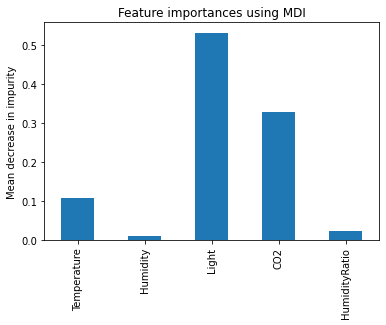

In [25]:
#Check feature importances with random forest
feature_names = [f"{X.columns[i]}" for i in np.arange(len(X.columns))]
importances = clf.best_estimator_.feature_importances_
std = np.std([clf.best_estimator_.feature_importances_ for tree in clf.best_estimator_.estimators_], axis = 0)
rf_importances = pd.Series(importances, index = feature_names)
fig, ax = plt.subplots()
rf_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

Now go through and remove the least important variable (or in first case the known to be derived variable of HumidityRatio which we will call HR), re-check the model and re-plot the feature importance with the remaining features.  From above we see that the most important is Light, fits with expectation from EDA section.  Lets see what happens here if we remove HumidityRatio, re-fit, re-plot.   
Removing HR gives best model as: loss function: gini, max depth: 2, balanced acc: 0.982 (keeping Temp, humid, light, co2)  
Try again removing Humidity as well as HR as humidity is the new lowest of importance  
Now see that best as:  loss function: entropy, max depth: 2, balanced acc: 0.981  (keeping temp, light, co2)  
Feature importance shows Light > CO2 > Temp (0.5 > 0.35 > 0.2 ish), clearly temp less important but still important enough. Interesting that it isn't more important than CO2 as might have been suggested from VIF analysis.  
Removing HR, Humidity, and Temp gives best as:  loss function: gini, max depth: 2, balanced acc: 0.985.  (keeping light, co2)  
Wow, it's great! And both have similar feature importance now.  
Comment out all of the plots other than the one with the full model and the one with the two-feature model to try to save some space.  Interesting also that Light and CO2 are correlated (corr coeff of 0.664) but by feature importance are the two left alive when assessing via the mean decreased impurity.  
Try also doing it with just light and temp as would be suggested by VIF analysis (though remember random forest can deal with some level of correlation so this may be expected)  
With light and temp get best as:  loss function: entropy, max depth: 2, balanced acc: 0.978  (keeping light, temp)  
If we keep only light we get best as:  loss function: gini, max depth: 1, balanced acc: 0.983. (keeping only light)   
Wow! Amazing accuracy, though this fits with what was expected from EDA.  Could keep model with just light, but this has a possible weakness: what if someone just left the lights on on accident?  Could absolutely justify using only Light as it is so good and a very easy thing to measure (one of the objectives of this report was the find a simple model that is easy to use), but could also justify keeping either Temperature or CO2 as a sort of 'backup'.  For now though since the objective was a model that was easy to gather data for and actually use, we will use Light alone.    

In [26]:
#split training into values and labels
# X = train[['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']] #Keep all predictors
# X = train[['Temperature', 'Humidity', 'Light', 'CO2']] #remove humidityratio as a variable
# X = train[['Temperature', 'Light', 'CO2']] #remove hr and humidity 
# X = train[['Light', 'CO2']] #remove hr, humidity, and temp
# X = train[['Light', "Temperature"]]
# X = train[['Light', 'Temperature']] #try keeping the two suggested by VIF analysis
X = train[['Light']] #try keeping only Light
y = train.iloc[:,-1] #keep only the labels, call it y
#start with random forest
# scoring = {"Accuracy": 'accuracy', 'Balanced Accuracy': 'balanced_accuracy'} #for comparing acc vs. balanced acc.
parameters = {'criterion':('gini', 'entropy'), 'max_depth':(None, 1, 2)} #set gridsearch params, keep max features as sqrt(n_features)
clf_base = RandomForestClassifier(random_state = 1236) #set random state for reproducability
clf = GridSearchCV(clf_base, parameters, refit = True, verbose = 1, cv = 5, scoring = 'balanced_accuracy') #have 5-fold CV instead of default 3, use balanced accuracy
#start timer for fit
start_rf = time.time()
clf.fit(X, y) #fit data
#end timer for fit
end_rf = time.time()
fit_time_rf = end_rf - start_rf
print(clf.best_params_)
print(clf.best_estimator_)
print(clf.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'criterion': 'gini', 'max_depth': 1}
RandomForestClassifier(max_depth=1, random_state=1236)
0.9827650882905585


In [27]:
#to see explicitly the feature importances
# clf.best_estimator_.feature_importances_

Since it would be silly to show the feature importance for just the one predictor of Light, showcase what it looks like for our three possible cases we ended up choosing.  Will re-fit using the two possible other predictors and plot all side by side to compare feature importances.

Text(0, 0.5, 'Mean decrease in impurity')

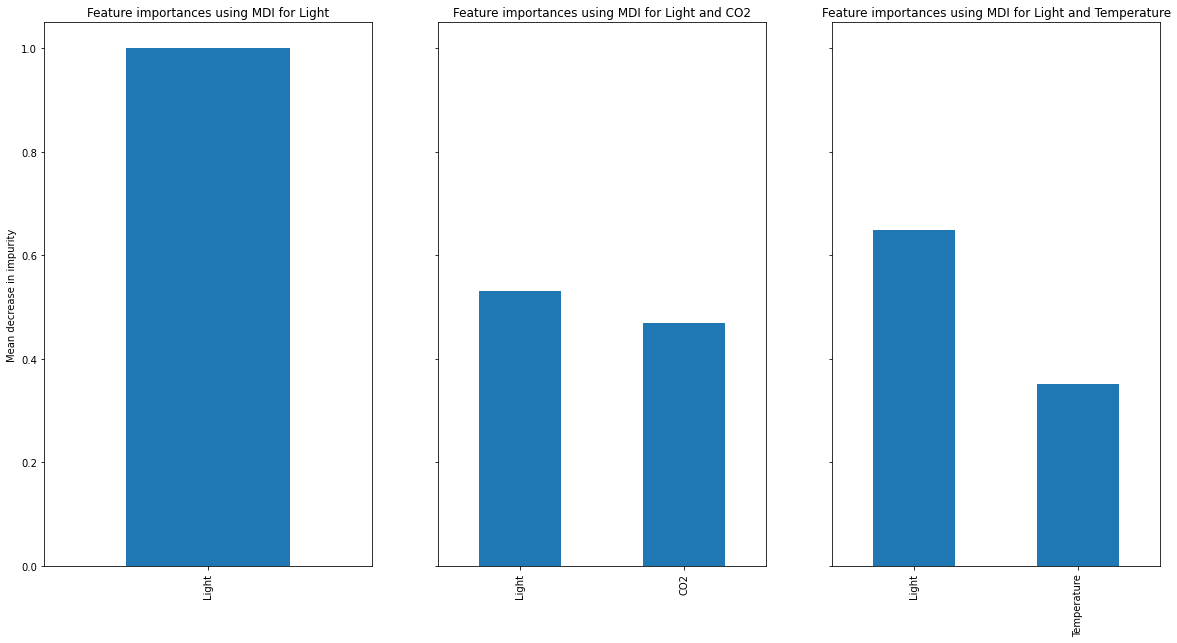

In [28]:
#Check feature importances for random forest model with Light alone
feature_names = [f"{X.columns[i]}" for i in np.arange(len(X.columns))] #take all the features from the X above
importances = clf.best_estimator_.feature_importances_ #get the feature importance values
std = np.std([clf.best_estimator_.feature_importances_ for tree in clf.best_estimator_.estimators_], axis = 0) #std calculations
rf_importances = pd.Series(importances, index = feature_names) #make the data into a series so as to plot easier
fig, axs = plt.subplots(1,3,sharey = True) #set up a 1x3 subplot grid
fig.set_size_inches(20,10) #set figure size
rf_importances.plot.bar(yerr=std, ax=axs[0]) #bar plot for light alone
axs[0].set_title("Feature importances using MDI for Light")
axs[0].set_ylabel("Mean decrease in impurity")


#refit with light+co2, plot feature importance as above
X_co2 = train[['Light', 'CO2']] 
parameters_co2 = {'criterion':('gini', 'entropy'), 'max_depth':(None, 1, 2)}
clf_base_co2 = RandomForestClassifier(random_state = 1236)
clf_co2 = GridSearchCV(clf_base_co2, parameters_co2, refit = True, verbose = 0, cv = 5, scoring = 'balanced_accuracy')  #set verbose=0 as we're just re-fitting to plot here
clf_co2.fit(X_co2, y) 
feature_names_co2 = [f"{X_co2.columns[i]}" for i in np.arange(len(X_co2.columns))]
importances_co2 = clf_co2.best_estimator_.feature_importances_
std_co2 = np.std([clf_co2.best_estimator_.feature_importances_ for tree in clf_co2.best_estimator_.estimators_], axis = 0)
rf_importances_co2 = pd.Series(importances_co2, index = feature_names_co2)
rf_importances_co2.plot.bar(yerr=std_co2, ax=axs[1])
axs[1].set_title("Feature importances using MDI for Light and CO2")
axs[1].set_ylabel("Mean decrease in impurity")


#same but with light + temp
X_temp = train[['Light', "Temperature"]]
parameters_temp = {'criterion':('gini', 'entropy'), 'max_depth':(None, 1, 2)}
clf_base_temp = RandomForestClassifier(random_state = 1236)
clf_temp = GridSearchCV(clf_base_temp, parameters_temp, refit = True, verbose = 0, cv = 5, scoring = 'balanced_accuracy') #set verbose=0 as we're just re-fitting to plot here
clf_temp.fit(X_temp, y) 
feature_names_temp = [f"{X_temp.columns[i]}" for i in np.arange(len(X_temp.columns))]
importances_temp = clf_temp.best_estimator_.feature_importances_
std_temp = np.std([clf_temp.best_estimator_.feature_importances_ for tree in clf_temp.best_estimator_.estimators_], axis = 0)
rf_importances_temp = pd.Series(importances_temp, index = feature_names_temp)
rf_importances_temp.plot.bar(yerr=std_temp, ax=axs[2])
axs[2].set_title("Feature importances using MDI for Light and Temperature")
axs[2].set_ylabel("Mean decrease in impurity")

Lets test the balanced accuracy of our full and reduced models for the linear SVC now  
Testing with fewer variables, form of missing predictors, cval, then balanced acc score  
All: 0.0477, 0.971  (light + co2 + temp + humidity + HR)  
-hr: 0.300, 0.971  (light + co2 + temp + humidity)  
-hr, humid: 0.03125, 0.977   (light + co2 + temp)  
-hr, humid, temp: 0.700, 0.973  (only light + co2)    
-hr, humid, co2: 1.236, 0.978  (only light + temp)    
-hr, humid, co2, temp: 0.3004, .979  (only light)  
Interestingly if we want something other than light (which again is amazing on its own), it would be temp here as suggested by VIF analysis, as opposed to light+co2 as suggested by random forest above.

In [29]:
#coming back to here to try clf2 with fewer variables, see if my linearsvc does better with just light + co2 as well
# X = train[['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']] #Keep all predictors
# X = train[['Temperature', 'Humidity', 'Light', 'CO2']] #remove humidityratio as a variable
# X = train[['Temperature', 'Light', 'CO2']] #remove hr and humidity 
# X = train[['Light', 'CO2']] #remove hr, humidity, and temp
# X = train[['Light', 'Temperature']] #try keeping the two suggested by VIF analysis
X = train[['Light']] #try keeping only Light
Cvals1 = np.logspace(-5, 5, 50, base=2) #possible Cvals to test with in gridsearch
param_grid = {'lin_SVC__C': Cvals1} #set param grid up, must re-name based on pipeline name
pipeline = Pipeline([("scaler" , StandardScaler(with_mean = True)), ('lin_SVC',LinearSVC(random_state = 1236, dual = False))]) #set dual = False as n_samples > n_features, sets up pipeline to scale features before gridsearch
clf2 = GridSearchCV(pipeline, param_grid, refit = True, verbose = 1, cv = 5, scoring = 'balanced_accuracy')
start_svc = time.time()
clf2.fit(X,y) #fit the SVC
end_svc = time.time()
fit_time_svc = end_svc - start_svc
print(clf2.best_params_)
print(clf2.best_estimator_[1])
print(clf2.best_score_)

# note that linear svc's do not have the ability to get the prediction probabilities out of them, must use CalibratedClassifierCV() on them to transform to get it. Do so first so we can get ROC Curves and AUC values in next section
#transform lin svc with calibratedclassifiercv() to get probabilities so we can make ROC curves
cali_svc = CalibratedClassifierCV(clf2.best_estimator_)
cali_svc.fit(X,y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'lin_SVC__C': 0.30047276230616354}
LinearSVC(C=0.30047276230616354, dual=False, random_state=1236)
0.9789888771075426


CalibratedClassifierCV(base_estimator=Pipeline(steps=[('scaler',
                                                       StandardScaler()),
                                                      ('lin_SVC',
                                                       LinearSVC(C=0.30047276230616354,
                                                                 dual=False,
                                                                 random_state=1236))]))

Basic tuning done, lets try using the best models chosen above on the test datasets to see what actually performs best.  Will try to use both Light + Temp and Light + CO2 models for both the RF and linear SVC and compare the balanced accuraccies on the test sets.

# Prompt: Results and Analysis
### Includes a summary with basic results and analysis and three of the following: Good amount of visualizations OR tries different evaluation metrics OR iterates training/evaluation and improving performance OR shows/discusses model performance
The possible models that I want to test on my test data are now the Random Forest and Linear SVC with (Light + CO2), (Light + Temp), and (Light) alone.  We also test a LogReg with (Light) alone after seeing how well the previous two models performed with (Light) alone.
Here we first check the accuracies and balanced accuracies of our RF and Linear SVC using the combinations of predictors on our test sets (of course going back and re-training with the applicable predictors first).  These accuracy scores are plotted and it is shown that based upon these metrics, the RF performs much better than the SVC on our test sets when using additional predictors other than Light, but comparably when using Light alone.  These accuracies when using Light alone are insanely high, but from what we've seen in our analysis so far this doesn't seem to be a case of data leakage but rather it's just the case that Light truly is an incredibly powerful predictor for the occupational state of a room.  We check two other metrics to assess our model both graphically and numerically.  We plot the ROCs and their associated AUC values as well as PRCs with their associated PRC-AUC values.  The ones left plotted are for the models with Light alone.  
The ROCs show that while both of these models are quite good and are generally comparable, the SVC works a little bit better for predicting on the first Test set as it has an AUC of 0.99 compared to the RF AUC of 0.983.  In the case where we have CO2 along with Light, the RF handedly beats out the SVC.  The case with Temperature is comparable to Light alone.  It is worth noting that ROC curves can be misleading for unbalanced data.  It is worth noting that ROC curves can be misleading for unbalanced data.   
Precision Recall Curves can be used in unbalanced data like ours which can create possibly misleading ROCs.  Here we see that again both models are comparable, but the RFs beat out the SVCs for Light alone.  The RFs again handedly beat out the SVCs when using CO2 and are comparable when using Temperature.  
Since we have found so much success in using Light alone, we will also now add on the most basic possible Logistic Regression.  This serves two purposes, the first is that it will be trained and fit directly in one cell with nothing else done to it so as to be able to ensure no data leakage occurs (or we can see all the code responsible if we did something wrong), and it also allows us the possibility of an insanely simple, easy to collect data for as well as use model to predict the occupancy status of a room which was the original goal of this project.  Here we find the following statistics for each test set for our LogReg:  
Test: Acc; 0.979, Balanced Acc; 0.983  
Test2: Acc; 0.992, Balanced Acc; 0.993  
This is incredibly close to the maximum scores we found through all our iterations in the RFs and Linear SVCs.  If we compare it to the previous best model of the RF with Light as the only predictor, we can see it reports identical scores for the first test set and a 0.001 decrease in both scores for the second test set.  We continue with the previous test statistics of ROCs, PRCs, and their associated scores. We can see again that the Logistic Regression performs nearly as well.  These tiny trade-offs in our so far chosen assessments of the model are offset by the incredibly quick timeframe in which the model can be fit and created, as shown further down.  The LogReg fits in somewhere under two hundredths of a second, whereas our otherwise best model of the RF fits in just over 5 whole seconds!  These are incredible savings in time, and well worth the honestly nearly negligible loss in accuracies.  
All of this comes together to show that all of the iterations and hyperparameter tuning that was done was absolutely unnecessary, and all that was really required to get my choice of best model for our selection criterion was a simple Logistic Regression.

light+co2 rf gave test: 0.978, 0.982 and test2: 0.986, 0.99   
light+temp rf gave test: 0.979, 0.983 and test2: 0.993, 0.994  
light+temp ends up being slightly better in test case for RF, contrary to VIF expectations as well as what was seen in feature importance! since we just wanted the 2nd variable to be a backup incase of accidents with light, seems fine to take temp instead.  note in report

In [30]:
#get test dataset X's and Y's for each combination of predictors.
# X_test = test[['Light', 'CO2']]
# X_test2 = test2[['Light', 'CO2']]
# X_test = test[['Light', 'Temperature']]
# X_test2 = test2[['Light', 'Temperature']]
X_test = test[['Light']]
X_test2 = test2[['Light']]
y_test = test.iloc[:,-1]
y_test2 = test2.iloc[:,-1]

#first test the random forest on first test set
test_pred_rf = clf.best_estimator_.predict(X_test)
test_rf_acc = np.sum(test_pred_rf == y_test)/len(y_test)
test_rf_bal_acc = balanced_accuracy_score(y_test, test_pred_rf)

#test random forest on second test set
test2_pred_rf = clf.best_estimator_.predict(X_test2)
test2_rf_acc = np.sum(test2_pred_rf == y_test2)/len(y_test2)
test2_rf_bal_acc = balanced_accuracy_score(y_test2, test2_pred_rf)

print(f"For the first test set we have an accuracy and balanced accuracy of: {round(test_rf_acc,3)}, {round(test_rf_bal_acc,3)} when using the random forest classifier with the predictors as {list(X_test.columns)}")
print(f"For the second test set we have an accuracy and balanced accuracy of: {round(test2_rf_acc,3)}, {round(test2_rf_bal_acc,3)} when using the random forest classifier with the predictors as {list(X_test.columns)}")

For the first test set we have an accuracy and balanced accuracy of: 0.979, 0.983 when using the random forest classifier with the predictors as ['Light']
For the second test set we have an accuracy and balanced accuracy of: 0.993, 0.994 when using the random forest classifier with the predictors as ['Light']


In [31]:
#create dataframe with all the scores to plot easily for RF
pred_list = ['Light+CO2', 'Light+Temp', 'Light']
acc_list_test = [0.978, 0.979, 0.979]
bal_acc_list_test = [0.982, 0.983, 0.983]
acc_list_test2 = [0.986, 0.993, 0.993]
bal_acc_list_test2 = [0.99, 0.994, 0.993]
d = {'Test Acc': acc_list_test, 'Test Bal Acc': bal_acc_list_test, 'Test2 Acc': acc_list_test2, 'Test2 Bal Acc':bal_acc_list_test2}
rf_test_scores = pd.DataFrame(data = d, index = pred_list)
# rf_test_scores

light+temp svc gave test: 0.979 and 0.983 and test2: 0.992, 0.993  
light+CO2 svc gave test: 0.979, 0.983 and test2: 0.991, 0.993  
light+temp clearly better for svc, and a tiny bit better for rf, use these two instead of light+co2

In [32]:
#now test the svc on first test set
test_pred_svc = clf2.best_estimator_.predict(X_test)
test_svc_acc = np.sum(test_pred_svc == y_test)/len(y_test)
test_svc_bal_acc = balanced_accuracy_score(y_test, test_pred_svc)

#test the svc on the second test set
test2_pred_svc = clf2.best_estimator_.predict(X_test2)
test2_svc_acc = np.sum(test2_pred_svc == y_test2)/len(y_test2)
test2_svc_bal_acc = balanced_accuracy_score(y_test2, test2_pred_svc)

print(f"For the first test set we have an accuracy and balanced accuracy of: {round(test_svc_acc,3)}, {round(test_svc_bal_acc,3)} when using the SVC and with the predictors as {list(X_test.columns)}")
print(f"For the second test set we have an accuracy and balanced accuracy of: {round(test2_svc_acc,3)}, {round(test2_svc_bal_acc,3)} when using the SVC and with the predictors as {list(X_test.columns)}")

For the first test set we have an accuracy and balanced accuracy of: 0.978, 0.982 when using the SVC and with the predictors as ['Light']
For the second test set we have an accuracy and balanced accuracy of: 0.989, 0.992 when using the SVC and with the predictors as ['Light']


In [33]:
#create dataframe with all the scores to plot easily for SVC
pred_list = ['Light+CO2', 'Light+Temp', 'Light']
svc_acc_list_test = [0.979, 0.979, 0.978]
svc_bal_acc_list_test = [0.983, 0.983, 0.982]
svc_acc_list_test2 = [0.991, 0.992, 0.989]
svc_bal_acc_list_test2 = [0.993, 0.993, 0.992]
d = {'Test Acc': svc_acc_list_test, 'Test Bal Acc': svc_bal_acc_list_test, 'Test2 Acc': svc_acc_list_test2, 'Test2 Bal Acc':svc_bal_acc_list_test2}
svc_test_scores = pd.DataFrame(data = d, index = pred_list)
# svc_test_scores

Clearly comparable results!  Compare timeframes.  Also since Light alone works so well we should check the simplest possible model before conclusion, use just a LogReg with Light alone

Text(0.5, 1.0, 'SVC Test Scores')

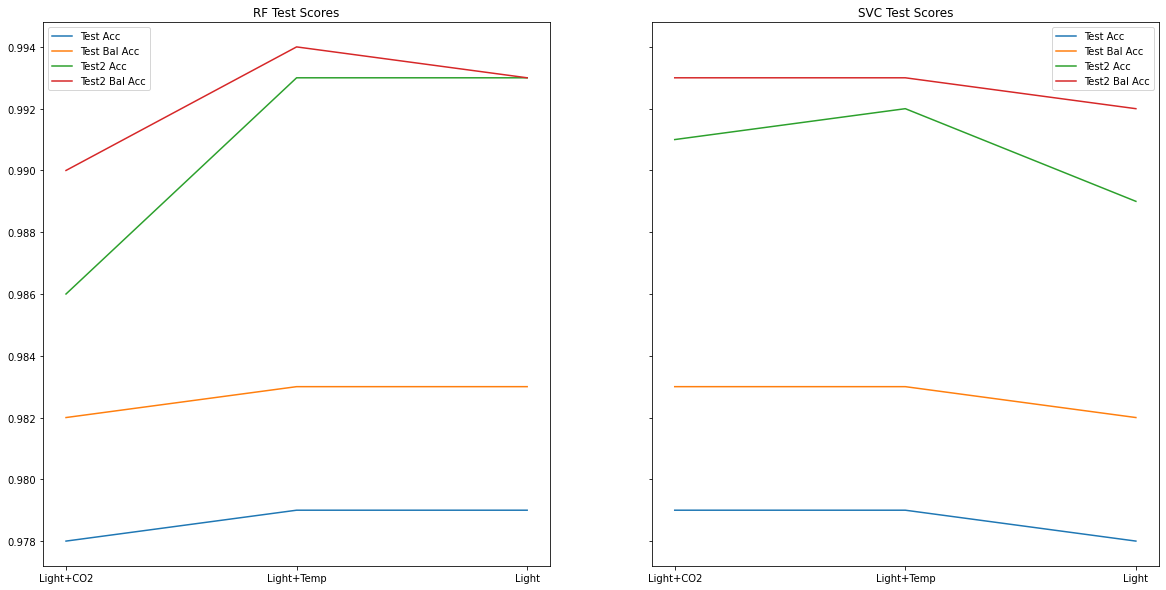

In [34]:
#plot normal and balanced accuracies on both test sets for SVC and RF
fig, axs = plt.subplots(1,2, sharey = True)
fig.set_size_inches(20,10)
axs[0].plot(rf_test_scores)
axs[0].legend(rf_test_scores)
axs[0].set_title("RF Test Scores")
axs[1].plot(svc_test_scores)
axs[1].legend(svc_test_scores.columns)
axs[1].set_title("SVC Test Scores")


Text(0.7, -0.175, 'AUC = 0.996')

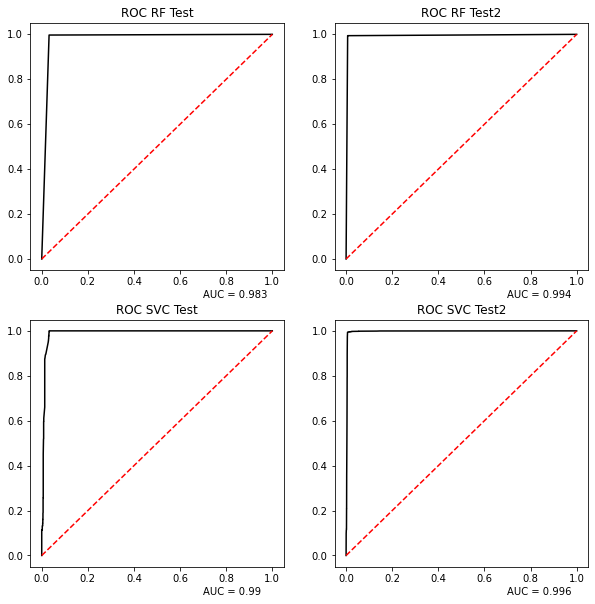

In [35]:
#check the ROC curves, set side-by-side, label
#get the actual data for the random forest ROC,PRC curves, first for test
ypp_test = clf.best_estimator_.predict_proba(X_test)
fpr_test, tpr_test, th_test = roc_curve(y_test, ypp_test[:,1])
auc_test = roc_auc_score(y_test, ypp_test[:,1]) 
prec_test, rec_test, _ = precision_recall_curve(y_test, ypp_test[:,1])
auc_pr_test = auc(rec_test, prec_test)
#data for rf for test2
ypp_test2 = clf.best_estimator_.predict_proba(X_test2)
fpr_test2, tpr_test2, th_test2 = roc_curve(y_test2, ypp_test2[:,1])
auc_test2 = roc_auc_score(y_test2, ypp_test2[:,1])
prec_test2, rec_test2, _ = precision_recall_curve(y_test2, ypp_test2[:,1])
auc_pr_test2 = auc(rec_test2, prec_test2)
#data for svc on test
ypp_test_svc = cali_svc.predict_proba(X_test)
fpr_test_svc, tpr_test_svc, th_test_svc = roc_curve(y_test, ypp_test_svc[:,1])
auc_test_svc = roc_auc_score(y_test, ypp_test_svc[:,1]) 
prec_test_svc, rec_test_svc, _ = precision_recall_curve(y_test, ypp_test_svc[:,1])
auc_pr_test_svc = auc(rec_test_svc, prec_test_svc)
#data for svc on test2
ypp_test2_svc = cali_svc.predict_proba(X_test2)
fpr_test2_svc, tpr_test2_svc, th_test2_svc = roc_curve(y_test2, ypp_test2_svc[:,1])
auc_test2_svc = roc_auc_score(y_test2, ypp_test2_svc[:,1]) 
prec_test2_svc, rec_test2_svc, _ = precision_recall_curve(y_test2, ypp_test2_svc[:,1])
auc_pr_test2_svc = auc(rec_test2_svc, prec_test2_svc)

fig, axs = plt.subplots(2,2)
fig.set_size_inches(10,10)
#plot the ROC curves starting with random forest on test (top left plot)
axs[0,0].plot(fpr_test, tpr_test, 'k-')
axs[0,0].plot(np.arange(0,1.1, 0.1), np.arange(0,1.1,0.1), 'r--')
axs[0,0].set_title('ROC RF Test')
axs[0,0].text(0.7, -.175, f'AUC = {round(auc_test,3)}')
#random forest on test2 (top right plot)
axs[0,1].plot(fpr_test2, tpr_test2, 'k-')
axs[0,1].plot(np.arange(0,1.1, 0.1), np.arange(0,1.1,0.1), 'r--')
axs[0,1].set_title('ROC RF Test2')
axs[0,1].text(0.7, -.175, f'AUC = {round(auc_test2,3)}')
#svc on test (bottom left)
axs[1,0].plot(fpr_test_svc, tpr_test_svc, 'k-')
axs[1,0].plot(np.arange(0,1.1, 0.1), np.arange(0,1.1,0.1), 'r--')
axs[1,0].set_title('ROC SVC Test')
axs[1,0].text(0.7, -.175, f'AUC = {round(auc_test_svc,3)}')
#svc on test2 (bottom right)
axs[1,1].plot(fpr_test2_svc, tpr_test2_svc, 'k-')
axs[1,1].plot(np.arange(0,1.1, 0.1), np.arange(0,1.1,0.1), 'r--')
axs[1,1].set_title('ROC SVC Test2')
axs[1,1].text(0.7, -.175, f'AUC = {round(auc_test2_svc,3)}')

AUC can be misleading for unbalanced data, also examine the precision recall curve (PRC)  
Fix text positioning!  
compare auc-pr values for each

In [36]:
print(auc_pr_test, auc_pr_test2, auc_pr_test_svc, auc_pr_test2_svc)

0.9726266800289879 0.9852367595462528 0.9702684399317629 0.9746571579650989


(0.0, 1.1)

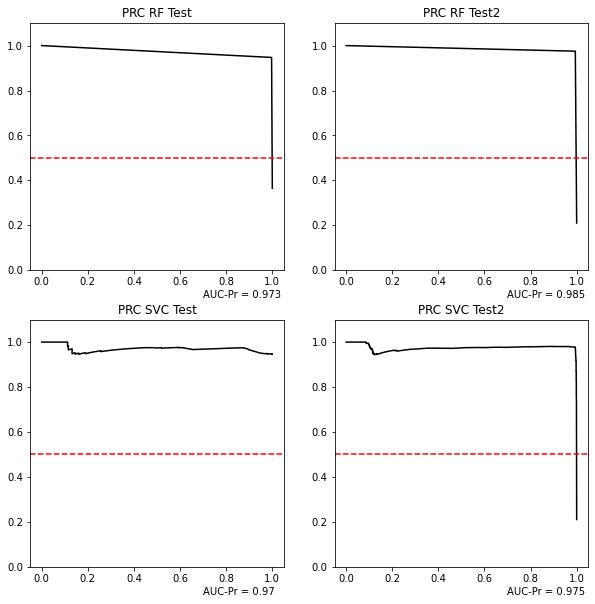

In [37]:
fig, axs = plt.subplots(2,2)
fig.set_size_inches(10,10)
#plot the PRC curves starting with random forest on test (top left plot)
axs[0,0].plot(rec_test, prec_test, 'k-')
axs[0,0].axhline(0.5, color = 'red', linestyle = '--')
axs[0,0].set_title('PRC RF Test')
axs[0,0].text(0.7, -.125, f'AUC-Pr = {round(auc_pr_test,3)}')
axs[0,0].set_ylim(0,1.1)
#random forest on test2 (top right plot)
axs[0,1].plot(rec_test2, prec_test2, 'k-')
axs[0,1].axhline(0.5, color = 'red', linestyle = '--')
axs[0,1].set_title('PRC RF Test2')
axs[0,1].text(0.7, -.125, f'AUC-Pr = {round(auc_pr_test2,3)}')
axs[0,1].set_ylim(0,1.1)
#svc on test (bottom left)
axs[1,0].plot(rec_test_svc, prec_test_svc, 'k-')
axs[1,0].axhline(0.5, color = 'red', linestyle = '--')
axs[1,0].set_title('PRC SVC Test')
axs[1,0].text(0.7, -.125, f'AUC-Pr = {round(auc_pr_test_svc,3)}')
axs[1,0].set_ylim(0,1.1)
#svc on test2 (bottom right)
axs[1,1].plot(rec_test2_svc, prec_test2_svc, 'k-')
axs[1,1].axhline(0.5, color = 'red', linestyle = '--')
axs[1,1].set_title('PRC SVC Test2')
axs[1,1].text(0.7, -.125, f'AUC-Pr = {round(auc_pr_test2_svc,3)}')
axs[1,1].set_ylim(0,1.1)

For the first test set we have an accuracy and balanced accuracy of: 0.979, 0.983 when using the random forest classifier with the predictors as ['Light']
For the second test set we have an accuracy and balanced accuracy of: 0.993, 0.994 when using the random forest classifier with the predictors as ['Light']

since it's so crazy accurate with just one predictor set up the simplest possible binary classifier and check accuracies

In [38]:
#LogReg model
from sklearn.linear_model import LogisticRegression
X_test = test[['Light']]
X_test2 = test2[['Light']]
y_test = test.iloc[:,-1]
y_test2 = test2.iloc[:,-1]
X = train[['Light']] #try keeping only Light
y = train.iloc[:,-1]
start_log = time.time()
clf_log= LogisticRegression().fit(X, y) #create and fit the logreg with light alone
end_log = time.time()
fit_time_log = end_log - start_log
pred_test = clf_log.predict(X_test) #predict on test
pred_test2 = clf_log.predict(X_test2) #predict on test2

clf_test_acc  = np.sum(pred_test == y_test)/len(y_test) #get test acc values
clf_test_bal_acc = balanced_accuracy_score(y_test, pred_test) #get test bal acc values

clf_test2_acc  = np.sum(pred_test2 == y_test2)/len(y_test2) #get test2 acc values
clf_test2_bal_acc = balanced_accuracy_score(y_test2, pred_test2) #get test2 bal acc values

print(f"For the first test set we have an accuracy and balanced accuracy of: {round(clf_test_acc,3)}, {round(clf_test_bal_acc,3)} when using the LogReg")
print(f"For the second test set we have an accuracy and balanced accuracy of: {round(clf_test2_acc,3)}, {round(clf_test2_bal_acc,3)} when using the LogReg")

For the first test set we have an accuracy and balanced accuracy of: 0.979, 0.983 when using the LogReg
For the second test set we have an accuracy and balanced accuracy of: 0.992, 0.993 when using the LogReg


Wow, LogReg with just light alone is amazing. and super fast. check other model assessment tools then plot times

(0.0, 1.1)

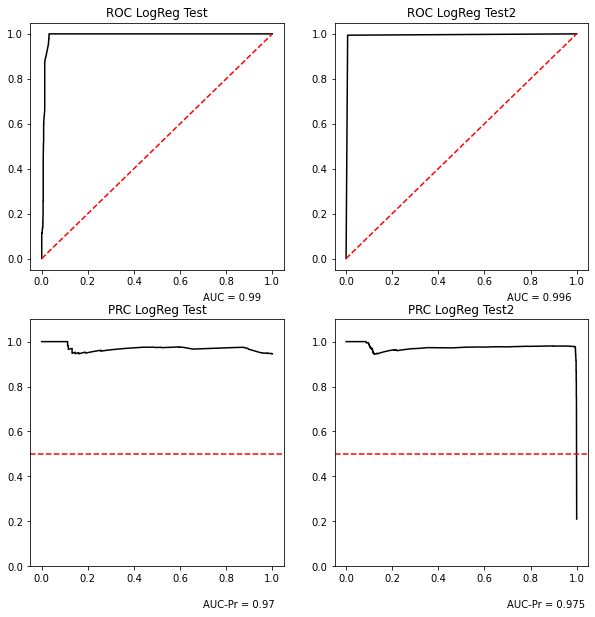

In [39]:
#get similar plots as above, starting with test
ypp_test_log = clf_log.predict_proba(X_test)
fpr_test_log, tpr_test_log, th_test_log = roc_curve(y_test, ypp_test_log[:,1])
auc_test_log = roc_auc_score(y_test, ypp_test_log[:,1]) 
prec_test_log, rec_test_log, _ = precision_recall_curve(y_test, ypp_test_log[:,1])
auc_pr_test_log = auc(rec_test_log, prec_test_log)
#same for test2
ypp_test2_log = clf_log.predict_proba(X_test2)
fpr_test2_log, tpr_test2_log, th_test2_log = roc_curve(y_test2, ypp_test2_log[:,1])
auc_test2_log = roc_auc_score(y_test2, ypp_test2_log[:,1]) 
prec_test2_log, rec_test2_log, _ = precision_recall_curve(y_test2, ypp_test2_log[:,1])
auc_pr_test2_log = auc(rec_test2_log, prec_test2_log)
fig, axs = plt.subplots(2,2)
fig.set_size_inches(10,10)
#plot the ROC curves starting with logreg on test (toopleft plot)
axs[0,0].plot(fpr_test_log, tpr_test_log, 'k-')
axs[0,0].plot(np.arange(0,1.1, 0.1), np.arange(0,1.1,0.1), 'r--')
axs[0,0].set_title('ROC LogReg Test')
axs[0,0].text(0.7, -.185, f'AUC = {round(auc_test_log,3)}')
#now ROC curve for test2 (top right plot)
axs[0,1].plot(fpr_test2, tpr_test2, 'k-')
axs[0,1].plot(np.arange(0,1.1, 0.1), np.arange(0,1.1,0.1), 'r--')
axs[0,1].set_title('ROC LogReg Test2')
axs[0,1].text(0.7, -.185, f'AUC = {round(auc_test2_log,3)}')
#PCR curve for test(bottom left)
axs[1,0].plot(rec_test_log, prec_test_log, 'k-')
axs[1,0].axhline(0.5, color = 'red', linestyle = '--')
axs[1,0].set_title('PRC LogReg Test')
axs[1,0].text(0.7, -.185, f'AUC-Pr = {round(auc_pr_test_log,3)}')
axs[1,0].set_ylim(0,1.1)
#PCR curve for test2 (bottom right)
axs[1,1].plot(rec_test2_log, prec_test2_log, 'k-')
axs[1,1].axhline(0.5, color = 'red', linestyle = '--')
axs[1,1].set_title('PRC LogReg Test2')
axs[1,1].text(0.7, -.185, f'AUC-Pr = {round(auc_pr_test2_log,3)}')
axs[1,1].set_ylim(0,1.1)

 Seems clear that we want simplest model, that is light alone with a LogReg.  Compare timings of each fit now before saying for sure

In [40]:
print(f"(Light alone) Time to fit RF: {fit_time_rf} s \n"
        f"(Light alone) Time to fit Linear SVC: {fit_time_svc} s \n"
        f"(Light alone) Time to fit LogReg: {fit_time_log} s")

(Light alone) Time to fit RF: 5.499485015869141 s 
(Light alone) Time to fit Linear SVC: 1.8104608058929443 s 
(Light alone) Time to fit LogReg: 0.016875028610229492 s


LogReg simplest model, fastest fit, amazing accuracy.  Clearly light alone is the best predictor, can add others as redundancies if you want (either Temp or CO2) but for what we wanted, LogReg with Light wins out.

Text(0.5, 0, 'Model')

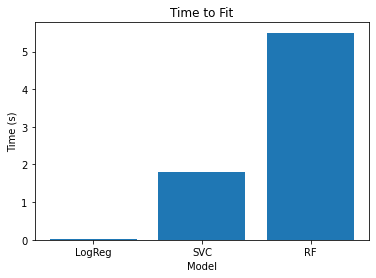

In [41]:
d = {fit_time_rf, fit_time_svc, fit_time_log}
label_names = ['LogReg', 'SVC', 'RF']
time_df = pd.DataFrame(data = d, index = label_names)
plt.bar(time_df.index,time_df[0])
plt.title("Time to Fit")
plt.ylabel("Time (s)")
plt.xlabel("Model")

# Discussion and Conclusion
### Discussion of learning and takeaways OR discussion of why something didn't work OR suggests ways to improve
The fact that at the end of all of this, the best choice with almost no concessions being made in accuracy is a simple Logistic Regression is almost disheartening.  As well as a bit confusing.  In the original paper, they used more sensors with much more complex models and found accuracies that were at best comparable (to be fair it's hard to get much better than we got here!) to ours.  I went in to this thinking that it would end up being a relatively complex problem due to the paper, but as far as I can tell, it is an incredibly simple problem which can be solved with only one sensor - one for Lux.  With that said there are some clear possible drawbacks of using only a light sensor in a meaningful way such as choosing heating/cooling of an office space, assignment of rooms, etc.  There could be issues with say reflections hitting sensors, or accidents where lights are left on, but these can be mitigated with some simple outlier analysis or by choosing one of the other predictors to go along with Light as a backup.  For instance using a CO2 and a Lux sensor together would provide a seemingly comprehensive coverage to account for lights being left on, or people working in the dark.   
The things which didn't end up working include almost all of the analysis we did!  While it was interesting to go through and piece by piece show why nothing ended up mattering other than Light, it is true that no part of what I originally intended to use was in my final model.  Though it could be the case that if we were in a situation where we added more sensors and had more raw data coming in, the SVC would end up prevailing as the number of predictors p gets large.  Or if there is too much correlation between the predictors, the RF could take over as the best possible model because of its inherent qualities of decorrelation.  If I had to point at the one thing that went the most 'wrong' it was that I didn't immediately start with the simplest possible model (in this case a LogReg) using the clearly highly predictive variable of Light as soon as I saw the correlation between Light and Occupancy in my correlation matrix.  I also shouldn't have assumed that the data was challenging just because such a large paper was written about it!  
The best ways to improve upon this model would be to first get more data.  Both for more buildings, and over a longer period of time.  With these factors we could attempt to build a more general model that can be applied to buildings in general, rather than this one which we just hope will be gerally applicable - but is only truly applicable to the building and timeframe for which the data was taken.  I also think that a lot of interesting work could be done with the time data, examining trends and periodicity on the scales of hours, days, weeks, etc.  An example of why this would be interesting could be to examine room occupancy during anticipated times around lunch breaks to see if people are staying in their offices to eat or going out.  This could perhaps motivate the addition of something as small as a snack stand or as large as making space for a small cafe for workers in an upcoming expansion.  Plotted below is a very simple example using the full dataset which unfortunately doesn't even cover a month of observation.  The training set has an even smaller timeframe making it that much harder to do any real temporal analysis for now.  
Finally something that could be done is instead of changing the metrics used to ones that can account for the imbalance in the class labels, we could instead sample from both classes evenly and do our analysis that way.  This would presumably produce similar results in this case, but it is uncertain how this might affect future analysis with more data.

In [42]:
train = pd.read_csv(".\Data\datatraining.txt")
test = pd.read_csv(".\Data\datatest.txt") 
test2 = pd.read_csv(".\Data\datatest2.txt") 
#full df to showcase possibilities in date info
df = pd.concat([train, test, test2], axis = 0)
df.reset_index(inplace = True) #reset indices

In [43]:
print(f"The training set has observations between {min(train.date)} and {max(train.date)}")

The training set has observations between 2015-02-04 17:51:00 and 2015-02-10 09:33:00


<AxesSubplot:xlabel='date'>

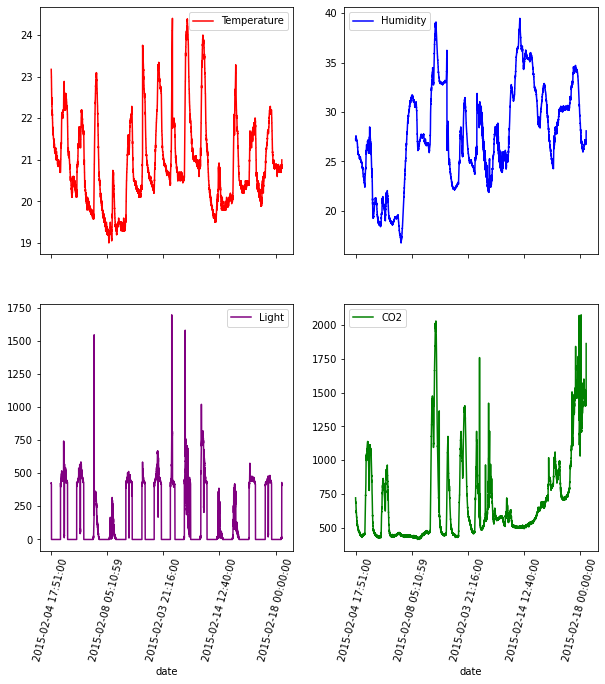

In [44]:
#see daily trends
fig, axs = plt.subplots(2,2, figsize = (10,10), sharex = True)
df.plot(x = 'date', y = 'Temperature', ax = axs[0,0], color = 'red', rot = 75)
df.plot(x = 'date', y = 'Humidity', ax = axs[0,1], color = 'blue', rot = 75)
df.plot(x = 'date', y = 'Light', ax = axs[1,0], color = 'purple', rot = 75)
df.plot(x = 'date', y = 'CO2', ax = axs[1,1], color = 'green', rot = 75)